# Web Scraping and Image Clustering
a. Collecting prices of products </br>
b. Creating price categories </br>
c. Image clustering via transfer learning (InceptionV3) and comparison to price categories </br>
d. Conclusion </br>

This script is censored to prevent any legal problems.

by Stefanie Müller

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import urllib.request
from bs4 import BeautifulSoup

## 1. Functions to gather data

In [2]:
#Creation of BeautifulSoup-Connection
def get_soup(url):
    html = urllib.request.urlopen(url)
    soup = BeautifulSoup(html, 'lxml')
    return soup

In [3]:
#Collection of all items
def get_all_items_from_soup(soup):
    all_items = soup.find_all('li', {'class':'productlisting-productlist-item'})
    #print(all_items)
    return all_items

In [4]:
#Collecting specified detail information
def get_item_details_as_df(all_items):

    def read_item_text(element, html_tag, class_name, fallback):
        search_result = element.find(html_tag, {'class': class_name})
        
        if search_result is None:
            return fallback
        else:
            return search_result.get_text()      
        
    list_rows = []

    for items in all_items:
        item_title = (items.find('span', {"class":"product-tile-name"}).get_text())
        #print(item_title)
        
        item_salePrice = (items.find('span', {"class":"ish-priceContainer-salePrice-value"}).get_text())
        #print(item_salePrice)      
        
        item_basicPrice = read_item_text(element=items, 
                                         html_tag='span', 
                                         class_name='product_basic_price', 
                                         fallback='-')
        item_basicPrice = item_basicPrice.strip('()')   
        #print(item_basicPrice)
        
        item_detailsURL = (items.find('a', {"class":"js-product-link"}).get("href"))    
        #print(item_detailsURL)
        
        item_imageURL = (items.find('div', {"class":"product-image-wrapper"}).find('img').get("data-src"))
        #print(item_imageURL)
        
        list_rows.append([item_title, item_salePrice, item_basicPrice, item_detailsURL, item_imageURL])

    df = pd.DataFrame(list_rows)  
    #display(df)
    return df

In [5]:
#Appending dfs (of each subpage)
def append_dfs(origin_df, new_df):
    df = origin_df.append(new_df)
    return df

In [6]:
#Splitting first column which contains the product title, size and types separated by a |
def split_first_column(df):
    df_name_split = df[0].str.split('|', expand=True)
    df1 = pd.concat([df_name_split.iloc[:,0:3], df.iloc[:, 1:]], axis=1)
    return df1

In [7]:
#Changing column header
def set_columns_header(list, df):
    df.columns = (list)
    return df

## 2. Gathering Data

In [8]:
df = pd.DataFrame()

#Collecting data from each subwebsite which contains the product information
for i in range(0,15):
    url = f"-censored-url-{i}"
    #print(url)

    soup = get_soup(url)
    all_items = get_all_items_from_soup(soup)
    if all_items is None or len(all_items) == 0:
        break
    
    df1 = get_item_details_as_df(all_items)

    df = append_dfs(df, df1)

df_ = split_first_column(df)

column_headers = ["Product Name", "Size", "Type", "Price", "Price per m", "Product URL", "Image URL"]

df_ = set_columns_header(column_headers, df_)
df_ = df_.reset_index(drop=True)

dfx = pd.DataFrame()
dfx["Price"] = df_["Price"]

dfx

,Price
0,"6,95 €"
1,"6,95 €"
2,"3,49 €"
3,"6,95 €"
4,"3,79 €"
...,...
477,"3,30 €"
478,"6,75 €"
479,"2,80 €"
480,"5,90 €"


## 3. Checking and preparing the data

In [9]:
#No missing prices
dfx.isna().sum()

Price    0
dtype: int64

In [10]:
#The prices needs to be changed to numeric type plus preprocessing to do so
df_prep = dfx.copy()
df_prep["Price"] = dfx["Price"].str.extract(r'(\d+,\d+)')
df_prep["Price"] = df_prep["Price"].str.replace(",", ".")
df_prep["Price"] = pd.to_numeric(df_prep["Price"])
df_prep

,Price
0,6.95
1,6.95
2,3.49
3,6.95
4,3.79
...,...
477,3.30
478,6.75
479,2.80
480,5.90


In [11]:
#Pricerange matches to information on the website
print (f'Pricerange is from {min(df_prep["Price"])}€ to {max(df_prep["Price"])}€')

Pricerange is from 0.8€ to 54.95€


In [12]:
#Creating Price Categories
bins = [0.00,5.00,10.00,np.inf]
labels = ["0", "1", "2"] #0=low, 1=medium, 2=high

df_prep["Price Category"] = pd.cut(df_prep["Price"], bins=bins, labels=labels)
df_prep

,Price,Price Category
0,6.95,1
1,6.95,1
2,3.49,0
3,6.95,1
4,3.79,0
...,...,...
477,3.30,0
478,6.75,1
479,2.80,0
480,5.90,1


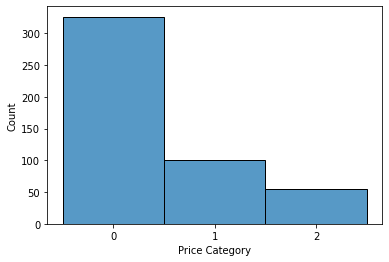

In [13]:
#Plotting Price Categories
sns.histplot(data=df_prep, x="Price Category")
plt.show()

## 4. Downloading Images for Clustering

In [14]:
#Example URL
#df_["Image URL"].iloc[0]

In [15]:
#Creating user agent for the connection
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

#Saving all images
for index, link in df_["Image URL"].iteritems():
    #print(index, link)
    #urllib.request.urlretrieve(link, f"images_downloaded/{index}.jpg") #saving all images

## 5. K-Means Clustering via transfer learning for feature selection
#### The idea is to see the price difference in the clusters because sets having higher prices compared to single products.

https://towardsdatascience.com/image-clustering-using-k-means-4a78478d2b83

In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.cluster import KMeans
from tqdm import tqdm
import os
import shutil

In [17]:
#Function for using InceptionV3 for feature selection from the images
def image_feature(direc):
    model = InceptionV3(weights='imagenet', include_top=False)
    features = [];
    img_name = [];
    for i in tqdm(direc):
        fname='images_downloaded'+'/'+i
        img=image.load_img(fname, target_size=(250,250))
        x = img_to_array(img)
        x=np.expand_dims(x,axis=0)
        x=preprocess_input(x)
        feat=model.predict(x)
        feat=feat.flatten()
        features.append(feat)
        img_name.append(i)
    return features,img_name

In [18]:
#Selecting features from the images
img_path=os.listdir('images_downloaded')
#print(img_path)
img_features,img_name=image_feature(img_path)

100%|████████████████████████████████████████████████████████████████████████████████| 482/482 [00:19<00:00, 24.95it/s]


In [19]:
#Creating Clusters
k = 3
clusters = KMeans(k, random_state = 42)
clusters.fit(img_features)

KMeans(n_clusters=3, random_state=42)

In [20]:
#Cluster Overview
image_cluster = pd.DataFrame(img_name,columns=['image'])
image_cluster["clusterid"] = clusters.labels_
image_cluster["clusterid"].value_counts()

0    189
2    154
1    139
Name: clusterid, dtype: int64

In [21]:
# Images will be seperated according to clusters they belong to for further investigation

#Create cluster
for i in range(k):
    if os.path.isdir(f'cluster{i}'):
        shutil.rmtree(f'cluster{i}')
    os.mkdir(f'cluster{i}')   

#Copy Images to cluster-folders
for i in range(len(image_cluster)):
    shutil.copy(os.path.join('images_downloaded', image_cluster['image'][i]), f'cluster{image_cluster["clusterid"][i]}')

In [22]:
%%capture --no-display 

#Clusters and Prices
cluster_price = pd.DataFrame()
cluster_price = df_prep[["Price Category", "Price"]]
cluster_price["Price Category"] = pd.to_numeric(cluster_price["Price Category"])

cluster_price["Cluster"] = image_cluster["clusterid"]

cluster_price

,Price Category,Price,Cluster
0,1,6.95,0
1,1,6.95,1
2,0,3.49,0
3,0,3.79,1
4,0,2.69,2
...,...,...,...
477,0,3.30,0
478,1,6.75,2
479,0,2.80,1
480,1,5.90,2


In [23]:
#Price Mean for each Cluster
cluster_price.groupby(['Cluster']).mean()

,Price Category,Price
Cluster,,
0,0.449735,6.652434
1,0.424460,6.447626
2,0.422078,6.068182


In [24]:
#Correlations -> there is none between the clusters and the price
cluster_price.corr('pearson')

,Price Category,Price,Cluster
Price Category,1.000000,0.805976,-0.017299
Price,0.805976,1.000000,-0.041366
Cluster,-0.017299,-0.041366,1.000000


## 6. Conclusion
The clusters gained by the features selected via InceptionV3 are not correlated to the three price categories. No matter if 2 or 3 clusters are chosen, the product sets were not separated from the single products. Even with 10 clusters this separation did not work out correctly.

Further inspection of different numbers of clusters showed a special behavior. With lots of clusters the images were primarily sorted by their product type but some of the images were sorted by cold and warm colortypes of the same product. Additionally products were grouped by if the image showed a shimmer or not. The net might not have been trained on this kind of product but on more complex topics which could explain these findings.